In [1]:
# # Run this cell then restart your kernel in google colab
# !pip install -r https://raw.githubusercontent.com/leolorenzoii/ml2_interpretability/main/requirements.txt

In [10]:
from numpy.testing import assert_equal, assert_almost_equal

decimal = 6

# Seatwork 2: Imba-SHAP

In this seatwork, we will handle an imbalanced binary classification problem and use `shap` to interpret the machine learning model.

We will also use the `Pipeline` class available in `imblearn.pipeline` and integrate it with a `StratifiedKFold` cross validated training step. We use `imblearn`'s implementation instead of `scikit-learn`'s implementation of `Pipeline` for better integration to resampling techniques.

*Note: Here, we don't employ hyperparameter tuning for brevity, but do note that in practice, we can tune parameters in our pipeline (e.g. `learning_rate`, `max_depth`).*

## SLT7A - Hao, Las, Mapa

## Situation

Suppose that you folks are a data scientist team working for a polyclinic company called **The Medical Republic**. One of the clinics,  called **Dia-Beat-This**, that specializes in diagnosis and treatment of diabetes in *PIMA Indian Women* observed that they have a long chain of tests conducted to determine precisely whether a person has diabetes or not. At each testing stage, both new procedures and results of previous testing stages are used to improve diagnosis--however, tests become more expensive at later stages.

![Candies](https://drive.google.com/uc?id=10rKNwjM9ZS25wURcURxqtT5zCU9I2koF)

**Enter ML:** You proposed to employ a machine learning algorithm to **predict the onset of diabetes** using only patient information at the earlier testing stages. Together with the medical team that you are working with, you drafted the following objective:

*Minimize the false negatives, find ALL positives.* Since the goal is to treat all patients with diabetes, you want to sensitively tag someone as positive, ensuring you don't send home a daibetic patient. Additionally, there are other more expensive testing stages (post-ML predictions) that can confirm false positives, so the risk of prescribing diabetes medication to negatives can be lowered by the pricey tests down the line.

## Data Dictionary

**Features**

We use all of the following quantitative features:
* `pregnancies` - number of pregnancies, number of times pregnant
* `glucose` - measure of blood sugar level in patients
* `blood pressure` - person's blood pressure readings during testing date
* `skin thickness` - an indicator of collagen content studied to be affected by insulin dependence of patients
* `insulin` - person's insulin levels, 2-hour serum insulin $\mu$ units/mL
* `bmi` - body-mass index (BMI, $kg/m^2$)
* `pedigree function` - measure of genetic influence based on patient relatives' history with diabetes.
* `age` - age in years

**Target:**
* `outcome` - indicator if person has diabetes or not: 
> `1` positive/diabetic, 
> `0` negative/no diabetes

To find out more about this dataset, see [link](https://machinelearningmastery.com/case-study-predicting-the-onset-of-diabetes-within-five-years-part-1-of-3/`). This is not necessary for the purposes of seatwork-2.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Preparation

In [12]:
df = pd.read_csv('https://drive.google.com/uc?id=1zTaNK2MkVW3gr6RRCHabbvY7jhn9F2PC')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        768 non-null    int64  
 1   glucose            768 non-null    int64  
 2   blood pressure     768 non-null    int64  
 3   skin thickness     768 non-null    int64  
 4   insulin            768 non-null    int64  
 5   bmi                768 non-null    float64
 6   pedigree function  768 non-null    float64
 7   age                768 non-null    int64  
 8   outcome            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [13]:
# df = pd.read_csv('diabetes.csv')
# df.info()

In [14]:
def plot_class_ratios(y):
    """Generate plot of class ratios from pd.Series input
    formatted to show ratios as annotations/bar labels.
    
    Parameter
        y : pd.Series of target array
    Return
        None
    """
    class_ratios = (y.value_counts()/y.shape[0])
    ax = class_ratios.plot.bar()
    ax.set_ylim(0.0, 1.0)
    ax.bar_label(ax.containers[0], fmt='%.2f', fontsize=12)
    plt.xticks(rotation=0)
    ax.set_xlabel('Class', fontsize=15)
    ax.set_ylabel('Ratio', fontsize=15, labelpad=10)
    ax.set_title('Class Ratios', fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return None

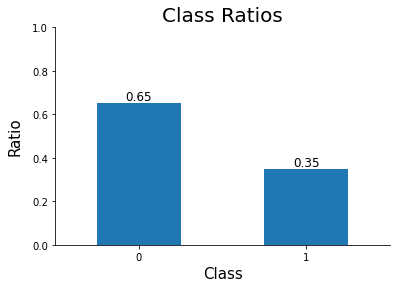

In [15]:
target = 'outcome'
plot_class_ratios(df[target])

In [70]:
df.outcome.value_counts()

0    500
1    268
Name: outcome, dtype: int64

## Data Segregation

### Task 1 [1 pt]

Split the dataset into `80-20` trainval-holdout sets, **ensure samples splitting is stratified according to the target array**. *Among other parameters* to be set, ensure that the following are set:

* `random_state=11`
* `test_size=0.20`

In [16]:
from sklearn.model_selection import train_test_split

# Initialize inputs
X, y = df.drop(columns=target), df[target]

# Perform a stratified train test split with test size = 0.20 and
# random state = 11
X_trainval, X_hold, y_trainval, y_hold = train_test_split(X,y, random_state = 11, test_size = .2, stratify = y)


In [17]:
# Assert
assert X_trainval is not None, 'Put x_train in this variable!'
assert X_hold is not None, 'Put x_test in this variable!'
assert y_trainval is not None, 'Put y_train in this variable!'
assert y_hold is not None, 'Put y_test in this variable!'

# Hidden tests

## Model Training

### Task 2 [2 pts]

To put emphasis on our objective, we shall structure our ML problem as an imbalanced classification problem. Thus, we shall depart from using `accuracy` as a metric.

In the problem, which metric will be most appropriate `recall` or `precision`? Why?

### Our chosen metric is RECALL.
We chose recall because diabetes-positive data points are the minority class and for this specific disease-related case, minimizing the false negatives is imperative because a false negative means somebody will live their life thinking that they don't have diabetes when they do. 

### Task 3 [1 pt]

Get the cross-validation score of an untuned/default intialized `GradientBoostingClassifier` using the `cross_val_score` function of `sklearn`. Initialize the following:

* `skf` - a stratified k-fold cross-validator with 4 splits
* `model` - an untuned/default `sklearn` gradient boosting classifer with `random_state=11`

Replace `None` with your answer.

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

# Initialize a stratified k-fold cross validator with 4 splits
skf = StratifiedKFold(n_splits=4)

# Initialize a Gradient Boosting Classifier with random state = 11 and
# other parameters set to default
model = GradientBoostingClassifier(random_state = 11)


In [19]:
# assert
assert skf is not None, 'Put Stratified KFold instance in this variable!'
assert model is not None, 'Put a Gradient Boosting Classifer instance this variable!'

## Model Evaluation

### Task 4 [1 pt]

Choose between `precision_score` or `recall_score` as a metric based on your answer in [**Task 2**](#Task-2-[2-pts]). Replace `metric=None` with your chosen metric.

Example: `metric=precision_score`

The rest of the code modifies your chosen metric into an `sklearn` `scorer`--this is already done for you.

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, make_scorer

metric = recall_score # precision_score or recall_score 

# make a metric into a scorer for the cross_val_score func
scorer = make_scorer(metric)

In [21]:
assert metric is not None, 'Put either precision_score/recall_score in this variable!'

### Task 5 [1 pt]

Calculate the average cross validation score and store it in the variable `average_cv_score`. *Note: `cross_val_score` returns an array of scores for each stratified train-val split (a.k.a. fold)*

In [22]:
cv_scores = cross_val_score(estimator=model, X=X_trainval, y=y_trainval,
                            scoring=scorer, cv=skf, n_jobs=-1)
average_cv_score = np.mean(cv_scores)


print(f"Average cv score: {average_cv_score:.2f}")

Average cv score: 0.61


In [23]:
assert average_cv_score is not None, 'Put the average cv score in this in this variable!'

### Task 6 [1 pt]

Retrain the `model` using the entire train-val set stored in `X_trainval` and `y_trainval` and calculate the score on the the holdout set.

Generate predictions on the holdout set `X_hold` and store the predictions in the variable `y_preds`. 

In [24]:
model.fit(X_trainval, y_trainval)

y_preds = model.predict(X_hold)


holdout_score = metric(y_hold, y_preds)
print(f"Holdout set score: {holdout_score:.2f}")

Holdout set score: 0.65


In [25]:
assert y_preds is not None, 'Put the predictions in y_preds!'
assert_equal(len(y_preds), len(X_hold))

## Model Interpretation (Part 1)

Now that we have a trained model, let us interpret our model using `shap`.

### Task 7 [1 pt]

Define the `shap` explainer. Use the appropriate explainer based on our trained model.

In [26]:
# !pip install shap

In [27]:
import shap

# Define the SHAP explainer here. What is the appropriate explainer that
# we should use in this case?
explainer = shap.TreeExplainer(model)


In [28]:
assert explainer is not None, "Initialize the shap explainer object here"

### Task 8 [1 pt]

Compute the shapley values of the features using the `shap_values()` method of the `explainer` object. Use the **hold-out test set** as reference.

In [29]:
shap_values = explainer.shap_values(X_hold)


In [30]:
assert shap_values is not None, "Place the shapley values here"

Now, let's look at how the model makes predictions. We observe that for patient `10` in the hold-out test set, our model predicts her to be diabetic.

In [31]:
model.predict(X_hold.iloc[[9]])

array([1])

### Task 9 [1 pt]

Generate the SHAP force plot explanation for patient `10`.

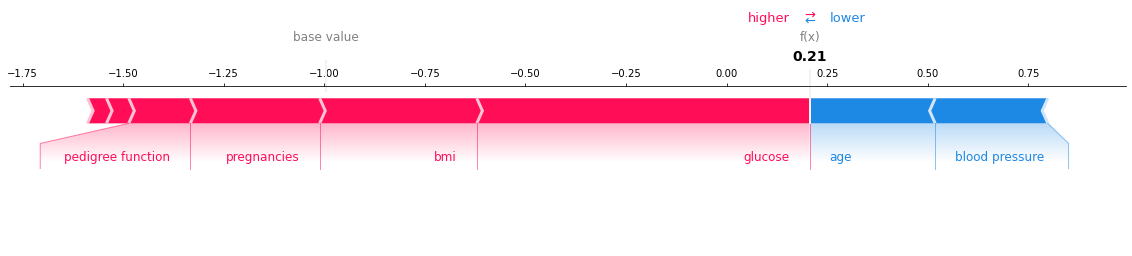

In [32]:
# Generate the SHAP force plot here for patient 10
shap.force_plot(explainer.expected_value, 
                shap_values[9], X_hold.columns, matplotlib=True)

### Task 10 [2 pts]

Interpret the results of the SHAP force plot. Explain as you would to a business stakeholder.

*Guide questions: What does the Shapley value mean for this problem? From the average prediction, how did the model arrive to its prediction? Interpret how each feature in the model contribute to the final prediction.*

For this problem, the shapley value predicts how likely a person has diabetes. A higher prediction means a higher chance of having diabetes, while lower predictions imply a lower chance of getting diabetes given the selected features. This prediction of 0.21 is higher than the base value (or average) of around -1.00. Looking at the features with the largest shapley values, glucose seems to be the largest diabetes predictor for patient 10, followed by bmi and pregnancies. Meanwhile, factors such as age and blood pressure act as resistance to the "push" generated by glucose and bmi. To verify our findings, we will look into a beeswarm plot in task 11. Smaller factors such as pedigree function, insulin, and skin thickness, also contributed to increasing the value of the prediction. These shapely values altogether predict that this patient is 1.21 above the naive prediction of -1.

In [38]:
shap_vals = shap_values[9]

feature_importance = pd.DataFrame(list(zip(X_hold.columns, shap_vals)),
                                  columns=['column_value', 'shap_vals'])

feature_importance.sort_values(by=['shap_vals'], 
                               ascending=False, 
                               inplace=True)

feature_importance

,column_value,shap_vals
1,glucose,0.827443
5,bmi,0.390571
0,pregnancies,0.321522
6,pedigree function,0.153102
4,insulin,0.055337
3,skin thickness,0.047104
2,blood pressure,-0.280131
7,age,-0.311988


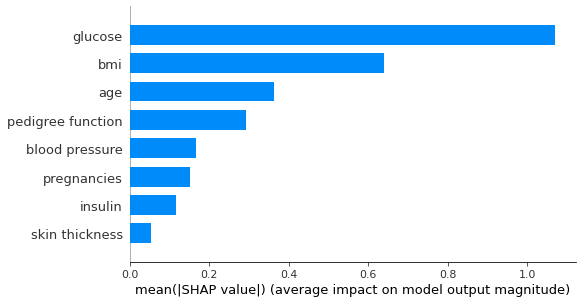

In [36]:
shap.summary_plot(shap_values=shap_values, 
                  features=X_hold, 
                  plot_type="bar")

Now, we want to interpret the results of the model on the entire dataset. We want a plot for global interpretability that combines feature importance with feature effects.

### Task 11 [1 pt]

Generate the SHAP beeswarm plot below using `shap.summary_plot()` function.

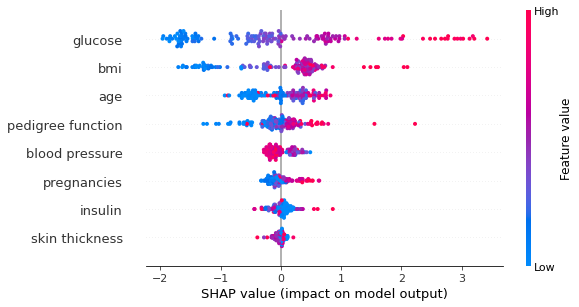

In [34]:
# Generate the SHAP beeswarm plot here
shap.summary_plot(shap_values = shap_values, 
                  features = X_hold)

### Task 12 [2 pts]

Interpret the resulting bee-swarm plot.

*Guide questions:*

*(1) In your plot, which feature is the strongest predictor for diabetes? Comment on the **SHAP values** and the **feature values** and how they impact the model output.*

*(2) Consider for example the `bmi` feature. Notice how the points are jittered or clustered together. Interpret this observation.*

1.) First of all, glucose is the strongest predictor for diabtes, followed by BMI. High values of glucose correspond to positive shap values, while a cluster of low values of glucose correspond to negative shapl values. However, one unique observation is the blood pressure feature, wherein high feature values correspond to negative shap values. 

2.) In the bmi feature, we can say that higher bmi levels would positively contribute to predicting a diabetes case. However a certain level of BMI doesn't strongly impact the output of the model, yet remains a positive shap value. This can be seen in medium-high BMI feature values clustered around low, but positive shap values (0-1). 

## Dataset Resampling

Let's now use `ADASYN` to resample our dataset. Here, we will use the `Pipeline` class of `imblearn` to put together different stages (e.g., preprocessing, model training) into one pipeline including the `ADASYN` resampling. We can then use and integrate our pipe with `sklearn`'s `cross_val_score` implemented in the previous task.

### Task 13 [1 pt]

Store in variable `ad` an initialized `ADASYN` resampler from `imblearn` with a `random_state=11`. Similar to **Task [3](#Task-3-[1-pt])**, you are to initialize an untuned/default `GradientBoostingClassifier` with a `random_state=11` and save it in `model`.

In [53]:
# resampling: ADASYN
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

ad = ADASYN(random_state=11)
model = GradientBoostingClassifier(random_state=11)


In [54]:
assert ad is not None, 'Put the ADASYN instance in ad!'
assert model is not None, 'Put a Gradient Boosting Classifer instance in the model variable!'

Now, let's evaluate our pipeline using `cross_val_score`.

In [55]:
# Generate new results: Run this after performing Task 13
pipeline = Pipeline([('adasyn', ad), ('gbc', model)])
cv_scores = cross_val_score(estimator=pipeline, X=X_trainval, y=y_trainval,
                            scoring=scorer, cv=skf, n_jobs=-1)

# Display average cross validation score
average_cv_score = np.mean(cv_scores)
print(f"Average cv score: {average_cv_score:.2f}")

# Refit and predict
pipeline.fit(X_trainval, y_trainval)
y_preds = pipeline.predict(X_hold)

holdout_score = metric(y_hold, y_preds)
print(f"Holdout set score: {holdout_score:.2f}")

Average cv score: 0.72
Holdout set score: 0.78


### Task  14 [1 pt]

Comment on the impact of `ADASYN` on the new average cv and holdout scores--compared against those obtained in **Tasks [5](#Task-5-[1-pt]) and [6](#Task-6-[1-pt])**.

(Recall: we are using recall) Comparing task 5 and task 6, task 5's average CV score was 0.61 while task 6's holdout score was 0.65. Using ADASYN, we got a higher average cv score of 0.72 and a higher holdout score of 0.78, a respectable increase. False negatives were therefore decreased in the resampled data, explaining the higher recall. (Statistical significance could be checked for the extra mile)

### Task 15 [1 pt]

Suppose a tuning step was done to obtain optimal hyperparameters of our `GradientBoostingClassifier`. Use the optimal hyperparameters now to re-train our pipeline on the `X_trainval` and `y_trainval` set. 

Again, **initialize** the `GradientBoostingClassifer` **using the hyperparameters below** and store it in the variable `model`.

**Optimal Hyperparameters of GBC**:
* `n_estimators=123`
* `max_depth=3`
* `learning_rate=0.018676197244611753`
* `random_state=11`, for reproduciblity

In [56]:
model = GradientBoostingClassifier(n_estimators=123, 
                                   max_depth=3, 
                                   learning_rate=0.018676197244611753,
                                   random_state=11)


In [57]:
assert model is not None, 'Put a Gradient Boosting Classifer with tuned hyperparameters this variable!'

In [58]:
# RUN AFTER TASK 15
# initialize the pipeline using the same ADASYN resampler ad and new model
pipeline = Pipeline([('adasyn', ad), ('gbc', model)])

# perform cross validation
cv_scores = cross_val_score(estimator=pipeline, X=X_trainval, y=y_trainval,
                            scoring=scorer, cv=skf, n_jobs=-1)

# calculate the average cv score
average_cv_score = np.mean(cv_scores)
print(f"Average cv score: {average_cv_score:.2f}")

# fit and predict
pipeline.fit(X_trainval, y_trainval)
y_preds = pipeline.predict(X_hold)

# get score on holdout set
holdout_score = metric(y_hold, y_preds)
print(f"Holdout set score: {holdout_score:.2f}")

Average cv score: 0.72
Holdout set score: 0.85


## Model Interpretation (Part 2)

Now let's interpret again our trained model. This time, we SHAP directly on our pipeline. We can achieve this using the `shap.KernelExplainer` object. We use our holdout test set as reference.

In [59]:
explainer = shap.TreeExplainer(
    pipeline['gbc'], feature_names=X_hold.columns,
)

### Task 16 [1 pt]

Compute for the shapley values of each features using the `shap_value()` method of the `explainer` object.

In [60]:
# # Ignore warnings for brevity
# import warnings
# warnings.filterwarnings('ignore')

# Compute the Shapley values using the `shap_value()` method of
# explainer. Use the hold-out test set as reference
shap_values = explainer.shap_values(X_hold)


In [61]:
assert shap_values is not None

We note that our model still predicts patient `10` to be diabetic.

In [62]:
pipeline['gbc'].predict(X_hold.iloc[[9]])

array([1])

### Task 17 [1 pt]

Generate the **SHAP Force Plot** model explanation for patient `10`.

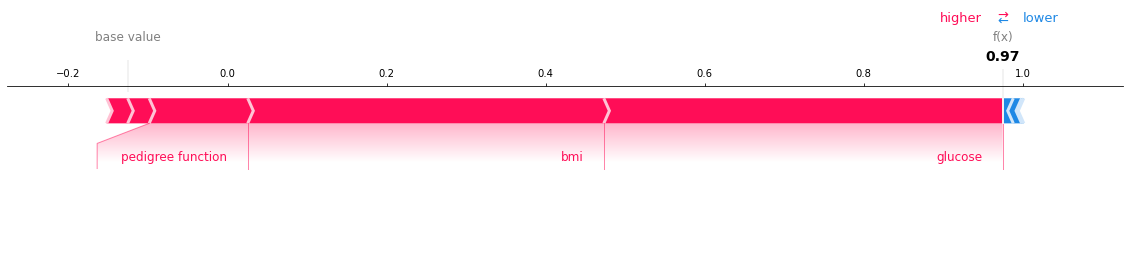

In [63]:
# Generate the SHAP force plot here
shap.force_plot(explainer.expected_value, 
                shap_values[9], X_hold.columns, matplotlib=True)

### Task 18 [1 pt]

Generate the **SHAP Beeswarm Plot** global model explanation for our pipeline.

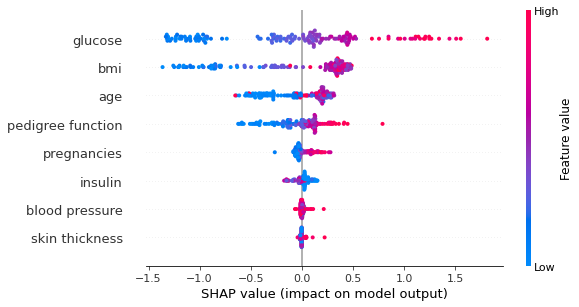

In [65]:
# Generate the beeswarm plot here
shap.summary_plot(shap_values = shap_values, 
                  features = X_hold)

### Task 19 [2 pts]

Enumerate at least **three** the differences you see between the model explanations for our tuned pipeline with resampling versus the prior model we used.

Hypothesize possible causes that changed the way the model behaved. Explain your answer as if you were talking to a business stakeholder after showing them this iteration or version of your model.

1.) There is a clear difference in BMI wherein for our resampled and retuned pipeline model's medium-high feature values, they are clustered between SHAP values of 0-0.5. Whereas for our prior model, there are high BMI feature values that can be described as outlier SHAP values of 1.5-2.5. 

2.) Blood pressure's SHAP values in the newer model are clustered closer to 0, whereas in our previous model, the SHAP values are further from 0. As such, in our resampled and retuned pipeline model's, blood pressure went from 5th to second to the last in terms of its impact on the output, when compared to the prior model.

3.) In the case of patient 10, we can observe in the resampled model that the shapley values increased to 0.97 because of a higher push from glucose and BMI compared to the former. We can also see that factors such as age and and blood reduced its impact to the shapley values for the resampled model.

### Explanation to a business stakeholder:

The reason we do **resampling** in the first place is because the data is imbalanced. The ratio of non-diabetic to diabetic cases is 65-35. The problem with accepting an answer using an imbalanced data is that the algorithm can give an answer based on pure chance- implying some sort of bias, which is unacceptable, especially for this specific case wherein getting false negatives (diabetic people classified as non-diabetic) can have very grave ramifications. 

So, the resampling method we used, ADAYSN, is an oversampling method wherein we "balance" the minority class with the majority class by creating synthetic data points for the minority class. This way, we deal with the bias created by the imbalanced data. As such, we are able to get a clearer picture of being able to predict the minority class, which in our case, are the diabetic patients. This is evidenced by a higher holdout recall score of 0.78 in our resampled model vs 0.65 in our prior model. What this means is we have a 13% higher chance of predicting diabetic people, which if we put in terms of the data, allows us to help 35 **more** people out of 268 diabetic cases.

### Task 20 [2 pts]

What are the potential limitations in our current iteration? What steps will you do to improve the model performance and explainability?

Our current iteration did not hypertune the resampling process and used only one modeling algorithm. Furthermore, we limited our interpretation to two plots: the force plot and the beeswarm plot.

In the case of resampling, hypertuning may result in synthetic data that better represent the real world scenario. In the case of modeling, using multiple models allows us to compare correctness of predictions even before assessing interpretability. Lastly, in terms of interpretability, we can explore other plots such as the SHAP dependence plot to obtain more information about the results.